In [1]:
from utils.common_imports import *
from IPython.display import display

# Get a annotation:
all_annotations: list[pl.Annotation] = pl.query(pl.Annotation).all()

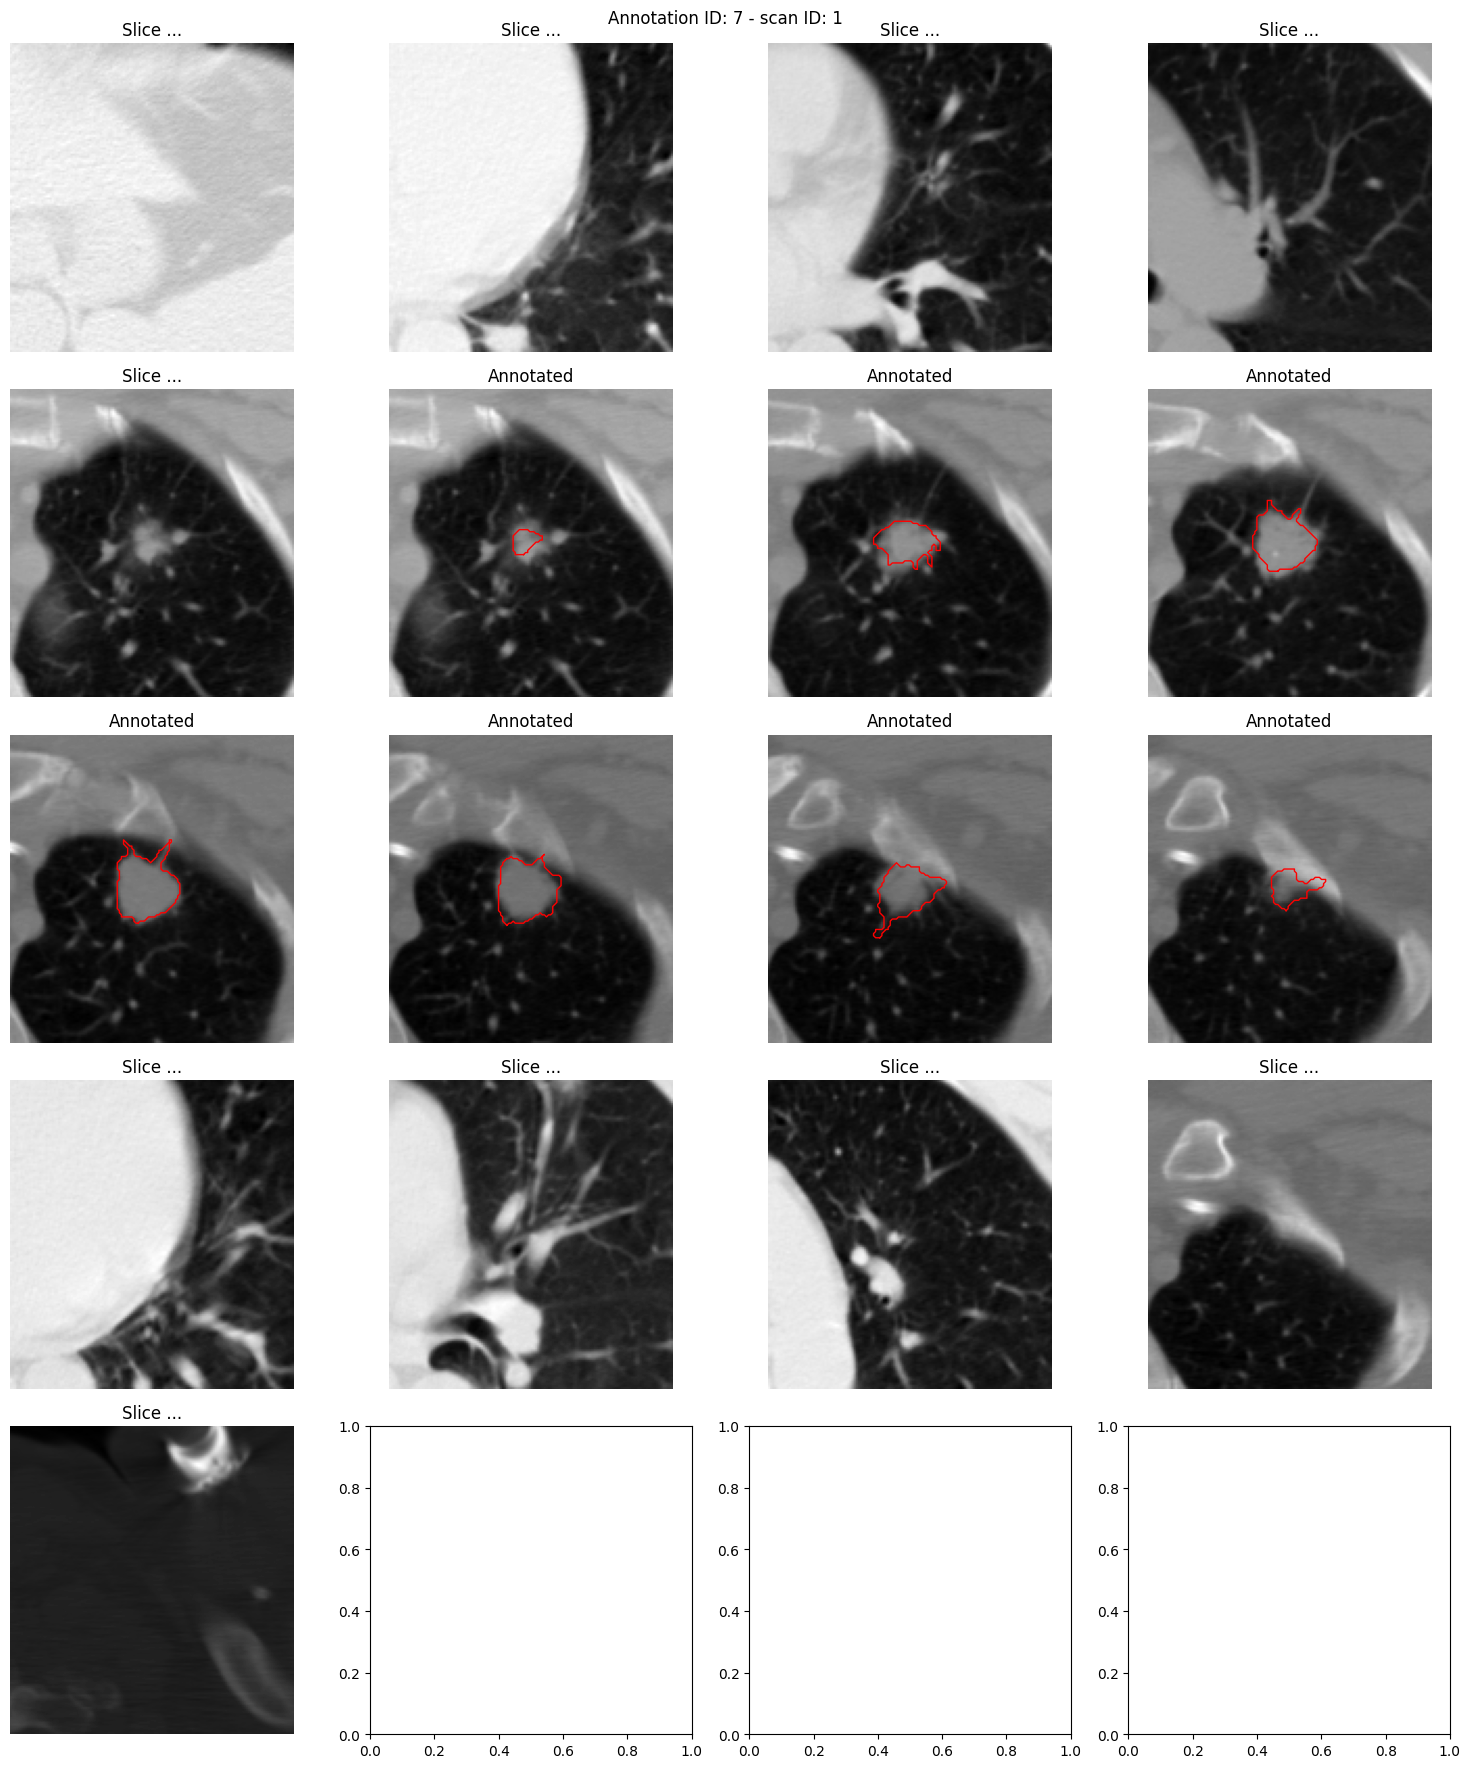

In [10]:
def get_roi_slices(ann: pl.Annotation, padding: int = 50) -> tuple[np.ndarray, np.ndarray]:
    """Given a annotation, returns a padded ROI volume and the dimensions of the bounding box of the ROI in the full scan."""
    vol = ann.scan.to_volume(verbose=False)
    roi_scan_bbox = ann.bbox()
    padded_roi_bbox = ann.bbox(pad=padding)
    return vol[padded_roi_bbox], roi_scan_bbox, padded_roi_bbox

def get_contour_values(annotations: list[pl.Annotation]):
    """Given a list of annotations, returns the contour values for each annotation."""
    pass

ann = all_annotations[6]

# Annotated slices
# TODO add all other annotations for the same nodule
all_contours = ann.contours
ann_scan_slice_idxs = ann.contour_slice_indices
ann_scan_slice_start_idx = int(ann_scan_slice_idxs[0])
ann_scan_slice_end_idx = int(ann_scan_slice_idxs[-1])

# get the ROI and its bounding box in the scan
padding = 50
roi, roi_scan_bbox, padded_roi_scan_bbox = get_roi_slices(ann, padding=padding)

# Subset the scans in the ROI that are annotated
pad_slice_min = padded_roi_scan_bbox[-1].start
pad_slice_max = padded_roi_scan_bbox[-1].stop
lower_bound = ann_scan_slice_start_idx - pad_slice_min
upper_bound = pad_slice_max - ann_scan_slice_end_idx
roi_annotated_subset = roi[:, :, lower_bound:-upper_bound + 1]

# display(roi_annotated_subset.shape)
# display(len(ann_scan_slice_idxs))
assert roi_annotated_subset.shape[-1] == len(ann_scan_slice_idxs), "The number of annotated slices in the ROI does not match the number of annotated slices in the annotation."

# Append n_append equally spaced slices before and after the annotated slices
n_append = 5
front_append_slice_idxs = np.linspace(start=0, stop=lower_bound, num=n_append, dtype=int)
back_append_slice_idxs = np.linspace(start=upper_bound, stop=roi.shape[-1] - 1, num=n_append, dtype=int)
roi_concat = np.concatenate([roi[:,:,front_append_slice_idxs], roi_annotated_subset, roi[:,:,back_append_slice_idxs]], axis=-1)


# Now display the slices in @roi_concat
show_contours = True

annotated_start_idx = n_append
annotated_end_idx = n_append + len(ann_scan_slice_idxs)

n_slices = roi_concat.shape[-1]
n_cols = 4
n_rows = (n_slices + n_cols -1) // n_cols

# for rescaling of the contours to match the crop:
padded_roi_bbox_x_min = int(padded_roi_scan_bbox[1].start)
padded_roi_bbox_y_min = int(padded_roi_scan_bbox[0].start)

# Plot figure:
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,18))
for i in range(n_slices):
    ax = axs[i//n_cols, i%n_cols]
    ax.imshow(roi_concat[:,:,i], cmap='gray')

    if annotated_start_idx <= i < annotated_end_idx and show_contours:
        # if the image is an annotated slice, plot the contours
        ax.set_title(f"Annotated")
        con = all_contours[i - annotated_start_idx]
        ii, jj = con.to_matrix(include_k=False).T
        # Rescale the contours to match the crop:
        jj = jj - padded_roi_bbox_x_min
        ii = ii - padded_roi_bbox_y_min
        ax.plot(jj, ii, '-r', lw=1, label="Nodule Boundary")

    else:
        ax.set_title(f"Slice ...")
    ax.axis('off')

plt.suptitle(f"Annotation ID: {ann.id} - scan ID: {ann.scan.id}")
plt.tight_layout()
plt.show()

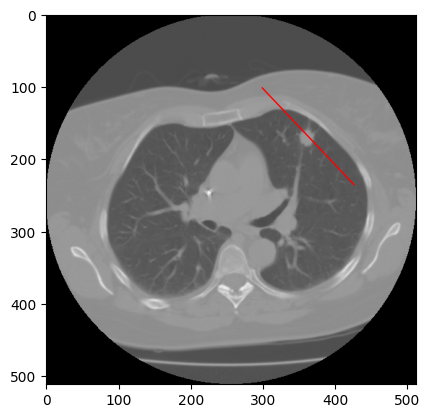

In [282]:
# DEBUGGING
vola = pl.query(pl.Annotation).filter(pl.Annotation.id == ann.id).first().scan.to_volume(verbose=False)
slice_idx = 46
plt.imshow(vola[:,:,slice_idx], cmap='gray')


plt.plot([x_min, x_max], [y_min, y_max], '-r', lw=1)
plt.show()

In [ ]:
# Visualise the ROI slices:
n_slices = roi_subset_slices.shape[-1]
n_cols = 4
n_rows = (n_slices + n_cols -1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 12))
for i in range(n_slices):
    ax = axs[i//n_cols, i%n_cols]
    ax.imshow(roi_subset_slices[:,:,i], cmap='gray')
    ax.set_title(f"Slice {scan_idxs[i]}")
    ax.axis('off')

plt.suptitle(f"Annotation ID: {ann.id} - scan ID: {ann.scan.id}")
plt.tight_layout()
plt.show()

In [7]:
# Extract the 3D ROI with padding:
padding = 50
n_examples = 15
bbox = ann.bbox(pad=padding)
roi = vol[bbox]
roi.shape

(134, 127, 87)

In [ ]:
# Get n_examples equally spaced slices from the total roi:
roi_example_slices = np.linspace(start=0, stop=roi.shape[-1] - 1, num=n_examples, dtype=int)
roi_subset = roi[:, :, roi_example_slices]

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(roi_subset[:, :, i], cmap='gray')
    ax.axis('off')
plt.suptitle(f'Total ROI slices: {roi.shape[-1]}, example slices: {roi_example_slices}')
plt.tight_layout()
plt.show()

Loading dicom files ... This may take a moment.


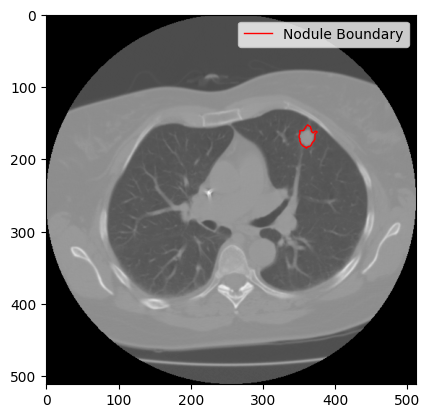

In [11]:
import pylidc as pl
import matplotlib.pyplot as plt

ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()
con = ann.contours[3]

k = con.image_k_position
ii,jj = ann.contours[3].to_matrix(include_k=False).T

plt.imshow(vol[:,:,46], cmap=plt.cm.gray)
plt.plot(jj, ii, '-r', lw=1, label="Nodule Boundary")
plt.legend()
plt.show()